# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn
import plotly.express as px

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-07 20:28:36.391885: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 20:28:36.440337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-07 20:28:36.441079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 20:28:37.200062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Define Constants, Functions

In [5]:
model_dir = "tft_model_16_tft_nogpp_7D_small_lr_230406_0405"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=8-step=360882.ckpt


In [6]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*7   # <------------------------------------ DOUBLE CHECK IT MATCHES WITH MODEL
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [7]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [8]:
def get_preds_actuals_agg(dataloader):
    # Get preds for site
    preds_q = best_tft.predict(dataloader, mode="quantiles", return_x=False)
    
    # Get actuals and mask from dataloader
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    actuals = actuals.reshape(-1)
    
    return preds_q, actuals, mask


def get_preds_actuals_masks_group(group_col, group_name, dec_ind_df):    
    preds_group = torch.tensor(dec_ind_df.loc[dec_ind_df[group_col]==group_name, 'preds'].values)
    actuals_group = torch.tensor(dec_ind_df.loc[dec_ind_df[group_col]==group_name, 'actuals'].values)
    mask_group = torch.tensor(dec_ind_df.loc[dec_ind_df[group_col]==group_name, 'mask'].values)
    
    return preds_group, actuals_group, mask_group


def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

## Prepare dataloaders for splits

In [9]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)
train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


## Select which split to evaluate

In [10]:
eval_split = 'val'

if eval_split == 'val':
    dataloader = validation
    split_df = val_df.copy()
elif eval_split == 'test':
    dataloader = test
    split_df = test_df.copy()

## Get all predictions and overall metrics

In [11]:
try:
    print("Loading quantile preds, actuals and mask from previous eval script")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "rb") as fin:
        actuals_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "rb") as fin:
        mask_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_p50.pkl", "rb") as fin:
        preds_p50_agg = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_q.pkl", "rb") as fin:
        preds_q_agg = pickle.load(fin)
        
except:
    print("Unable to load preds, mask, actuals. Running these now...")
    preds_q_agg, actuals_agg, mask_agg = get_preds_actuals_agg(dataloader)
    preds_p50_agg = preds_q_agg[:, :, 3].reshape(-1)

    # save values
    print("Saving out pickle files for model results")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "wb") as fout:
        pickle.dump(actuals_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "wb") as fout:
        pickle.dump(mask_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_p50.pkl", "wb") as fout:
        pickle.dump(preds_p50_agg, fout)

    with open(exp_model_dir + os.sep + f"{eval_split}_preds_q.pkl", "wb") as fout:
        pickle.dump(preds_q_agg, fout)
        

# Get results
rmse_agg, mae_agg, nse_agg = get_eval_metrics_simple(actuals_agg, preds_p50_agg, mask_agg)
print(f" Average metrics for {eval_split}: RMSE={rmse_agg}, MAE={mae_agg}, NSE={nse_agg}")

Loading quantile preds, actuals and mask from previous eval script
 Average metrics for val: RMSE=3.6365740299224854, MAE=2.0205183029174805, NSE=0.7481076121330261


In [12]:
# Create a dataframe for the decoded index of dataloader
dec_ind_df = pd.DataFrame(dataloader.decoded_index)
dec_ind_df = pd.merge(dec_ind_df, split_df[['site_id', 'IGBP']].drop_duplicates(), how='left', on='site_id')

# Append to DF
dec_ind_df['preds'] = preds_p50_agg
dec_ind_df['actuals'] = actuals_agg
dec_ind_df['mask'] = mask_agg
dec_ind_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_preds_actuals_mask.csv'))

dec_ind_df.head(3)

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction,IGBP,preds,actuals,mask
0,AU-DaP,350640,350808,350808,GRA,0.11356,0.27459,True
1,AU-DaP,350641,350809,350809,GRA,0.04891,-0.52453,True
2,AU-DaP,350642,350810,350810,GRA,-0.08105,0.09308,True


## Get performance metrics by val site

In [13]:
# Prep Site Loop
site_metrics = pd.DataFrame(columns=['site_id', 'rmse', 'mae', 'nse'])
site_metrics.loc[len(site_metrics)] = ['Average', rmse_agg, mae_agg, nse_agg]
sites = val_df['site_id'].unique()

for site in tqdm(sites):
    preds_group, actuals_group, mask_group = get_preds_actuals_masks_group('site_id', site, dec_ind_df)
    rmse, mae, nse = get_eval_metrics_simple(actuals_group, preds_group, mask_group)
    site_metrics.loc[len(site_metrics)] = [site, rmse, mae, nse]

site_metrics.to_csv(os.path.join(exp_model_dir, f'{eval_split}_site_level_metrics.csv'), index=False)
site_metrics.head()

100%|██████████| 26/26 [00:04<00:00,  6.28it/s]


,site_id,rmse,mae,nse
0,Average,3.63657,2.02052,0.74811
1,AU-DaP,4.34154,2.70116,0.68368
2,AU-Emr,4.15795,2.10741,-1.19712
3,AU-Gin,2.82438,1.82881,0.51738
4,AU-How,4.21255,2.61327,0.73594


#### Get median of site-level metrics

In [14]:
med_site_rmse = site_metrics['rmse'].median()
med_site_mae = site_metrics['mae'].median()
med_site_nse = site_metrics['nse'].median()
print(f"Median Site RMSE: {med_site_rmse}, Median Site MAE: {med_site_mae}, Median Site NSE: {med_site_nse}")

Median Site RMSE: 3.6365740299224854, Median Site MAE: 2.1074132919311523, Median Site NSE: 0.6836820244789124


## Get performance metrics by IGBP

In [15]:
# Prep Site Loop
igbp_metrics = pd.DataFrame(columns=['IGBP', 'rmse', 'mae', 'nse'])
igbp_metrics.loc[len(igbp_metrics)] = ['Average', rmse_agg, mae_agg, nse_agg]
igbps = val_df['IGBP'].unique()

for igbp in tqdm(igbps):
    preds_group, actuals_group, mask_group = get_preds_actuals_masks_group('IGBP', igbp, dec_ind_df)
    rmse, mae, nse = get_eval_metrics_simple(actuals_group, preds_group, mask_group)
    igbp_metrics.loc[len(igbp_metrics)] = [igbp, rmse, mae, nse]

igbp_metrics.to_csv(os.path.join(exp_model_dir, f'{eval_split}_igbp_level_metrics.csv'), index=False)
igbp_metrics.head()

100%|██████████| 9/9 [00:01<00:00,  6.23it/s]


,IGBP,rmse,mae,nse
0,Average,3.63657,2.02052,0.74811
1,GRA,4.00283,2.22345,0.68820
2,WSA,3.77671,2.33364,0.71990
3,ENF,3.32876,1.87823,0.72634
4,MF,4.51234,2.45213,0.14980


## View top and bottom site w/ metrics

In [16]:
sort_by = 'nse'
site_metrics.sort_values(sort_by, ascending=False, inplace=True)
print(f"Top site (in terms of {sort_by})")
display(site_metrics.head(5))

site_metrics.sort_values(sort_by, ascending=True, inplace=True)
print(f"Bottom site (in terms of {sort_by})")
display(site_metrics.head(5))

Top site (in terms of nse)


,site_id,rmse,mae,nse
15,GF-Guy,3.12837,2.30315,0.92022
10,DE-Hai,3.03521,1.66208,0.85562
12,FI-Hyy,2.24349,1.21922,0.84093
11,DK-Sor,4.06739,2.29128,0.83035
21,US-Bar,2.90585,1.55578,0.81203


Bottom site (in terms of nse)


,site_id,rmse,mae,nse
23,US-Mpj,3.77628,2.57354,-1.84179
2,AU-Emr,4.15795,2.10741,-1.19712
18,SE-Deg,1.94474,1.01181,-0.58839
7,CA-Gro,4.51234,2.45213,0.14980
25,US-Ses,0.63531,0.39693,0.24642


## View top and bottom IGBP w/ metrics

In [17]:
sort_by = 'nse'
igbp_metrics.sort_values(sort_by, ascending=False, inplace=True)
print(f"Top site (in terms of {sort_by})")
display(igbp_metrics.head(5))

igbp_metrics.sort_values(sort_by, ascending=True, inplace=True)
print(f"Bottom site (in terms of {sort_by})")
display(igbp_metrics.head(5))

Top site (in terms of nse)


,IGBP,rmse,mae,nse
7,EBF,3.12837,2.30315,0.92022
6,DBF,3.51763,1.93796,0.83018
0,Average,3.63657,2.02052,0.74811
3,ENF,3.32876,1.87823,0.72634
2,WSA,3.77671,2.33364,0.71990


Bottom site (in terms of nse)


,IGBP,rmse,mae,nse
9,OSH,2.66528,1.44938,-1.02046
8,WET,1.94474,1.01181,-0.58839
4,MF,4.51234,2.45213,0.14980
1,GRA,4.00283,2.22345,0.68820
5,CRO,4.52312,2.45203,0.69380


## Plot Site Performance on Map

In [18]:
# Load in site metadata, merge
site_metadata_filename = data_dir + os.sep + 'site-metadata.csv'
meta = pd.read_csv(site_metadata_filename, usecols=['site_id', 'lat', 'long'])

# Merge into site metrics
site_metrics = pd.merge(site_metrics, meta, on='site_id', how='left')

In [32]:
# Select metric to plot on map (lower case)
plot_metric = 'rmse'

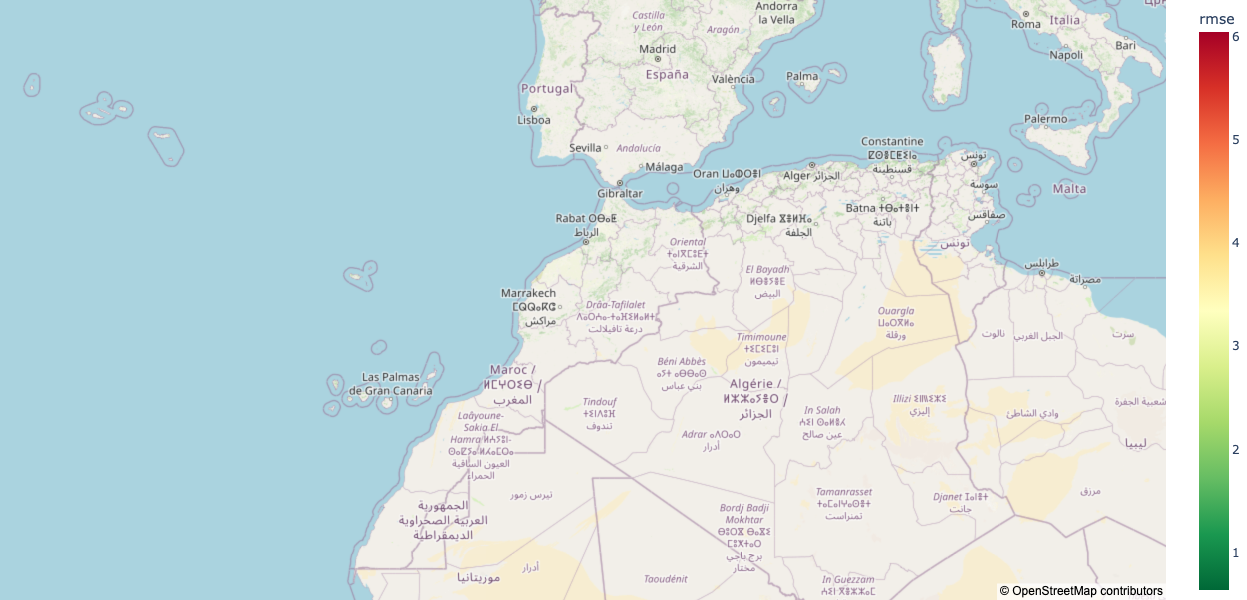

In [35]:
# Format
if (plot_metric == 'rmse') | (plot_metric == 'mae'):
    color_scale = "RdYlGn_r"
else:
    color_scale = "RdYlGn"

# Plot
fig = px.scatter_mapbox(site_metrics, lat="lat", lon="long", color=plot_metric, 
                        color_continuous_scale=color_scale, 
                        size="rmse", hover_name="site_id", zoom=4, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()